## ConvNet - dont need feature vectors

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

%matplotlib inline

## Load Data - X, Y

In [2]:
#Load the training and testing data, X is images, y are labels
BASE_IM_DIR = '/Users/Gabrielle/Kaggle/dog_breeds/train'

img_path_list = [file_name for file_name in os.listdir(BASE_IM_DIR) if file_name.endswith('jpg')]

In [6]:
img_list = []
for im_ind, im_file_path in enumerate(img_path_list):
    if im_ind % 100 ==0:
        print (im_ind)
    # reading the image
    img = cv2.imread(os.path.join(BASE_IM_DIR, im_file_path))
    # converting from bgr to rgb
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # resizing
    img = cv2.resize(img,(50,50))
    # add dummy dimension
    img_list.append(img)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200


In [48]:
labels_df = pd.read_csv('/Users/Gabrielle/Kaggle/dog_breeds/labels.csv') # id = image_name, breed = breed

Y_list = []
for im_path in img_path_list:
    breed_label = str(labels_df[labels_df['id'] == im_path[:-4]]['breed'].values[0])
    Y_list.append(breed_label)

In [66]:
X = np.array(img_list)
Y = np.array(Y_list) # len(Y) == 10222

### Normalising images

In [67]:
X = X.astype(np.float)
X /= 255.0

In [68]:
print(X.shape, Y.shape) # just checking. Dont need to add dummy dimensions because the photos are RGB (unlike the fasion MNIST greyscale)

(10222, 50, 50, 3) (10222,)


In [73]:
print(len(set(Y))) # No of unique labels

120


## After running conv_model.fit, we got an error 
`ValueError: Error when checking target: expected activation_23 to have shape (None, 120) but got array with shape (7155, 1)`
=> need to one hot encode our labels (120 in total)

In [74]:
Y = pd.get_dummies(Y) # one-hot encoding
print(Y.shape)

(10222, 120)


## Split X Y into train val test

In [75]:
train_percent = 0.7
val_percent = 0.2
test_percent = 0.1

total_samples = len(Y)

train_index   = int(total_samples * train_percent)
val_index     = int(total_samples * val_percent)
test_index    = int(total_samples * test_percent)

X_train = X[:train_index]
X_val  = X[train_index: train_index + val_index]
X_test  = X[train_index + val_index :]

Y_train = Y[:train_index]
Y_val   = Y[train_index: train_index + val_index]
Y_test  = Y[train_index + val_index :]

print(len(X_train) + len(X_val) + len(X_test) == len(X))


True


In [78]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import  Flatten
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1) 

conv_model1 = Sequential()
conv_model1.add(Convolution2D(
                        filters=20,
                        kernel_size=3,
                        activation='relu',
                        padding='valid', # take care of padding for me
                        input_shape=(50, 50,3)))
conv_model1.add(Activation('relu'))
conv_model1.add(MaxPooling2D( pool_size = (2,2)))
conv_model1.add(Dropout(0.5))
conv_model1.add(Flatten())
conv_model1.add(Dense(120))
conv_model1.add(Activation('softmax'))

conv_model1.compile(loss='categorical_crossentropy', # NOT BINARY_CROSSENTROPY
              optimizer='adam', # ADAM
              metrics=['accuracy'])

history = conv_model1.fit(X_train, Y_train, batch_size=30, 
          epochs=100,verbose=1,
          validation_data=(X_val, Y_val),
          callbacks=[early_stop])

Train on 7155 samples, validate on 2044 samples
Epoch 1/100
7155/7155 [==============================] - 24s 3ms/step - loss: 4.8134 - acc: 0.0147 - val_loss: 4.6808 - val_acc: 0.0342
Epoch 2/100
7155/7155 [==============================] - 19s 3ms/step - loss: 4.0678 - acc: 0.1248 - val_loss: 4.4969 - val_acc: 0.0509
Epoch 3/100
7155/7155 [==============================] - 19s 3ms/step - loss: 2.7813 - acc: 0.3895 - val_loss: 4.7404 - val_acc: 0.0558
Epoch 4/100
7155/7155 [==============================] - 19s 3ms/step - loss: 1.7104 - acc: 0.6274 - val_loss: 5.2511 - val_acc: 0.0587
Epoch 5/100
7155/7155 [==============================] - 20s 3ms/step - loss: 0.9946 - acc: 0.7976 - val_loss: 5.5713 - val_acc: 0.0572
Epoch 6/100
7155/7155 [==============================] - 20s 3ms/step - loss: 0.5822 - acc: 0.8889 - val_loss: 6.0059 - val_acc: 0.0509
Epoch 00006: early stopping


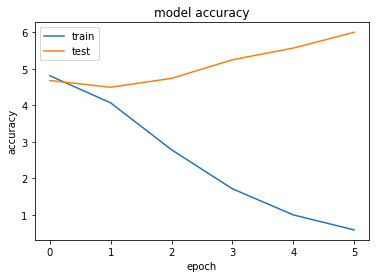

In [79]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

### Well 0.8 accuracy sucks... probably because there are 120 labels. vs the other examples of CIFAR, MNIST - 10 labels only. Will have to train a better model